In [60]:
# Imports
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import optuna
import joblib
from statistics import mean 
import math
import torch

from darts import TimeSeries
from darts.models import BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable


import warnings
warnings.filterwarnings('ignore')

# Configuration

In [61]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [62]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['An Giang', 'BR Vũng Tàu', 'Bình Phước']

In [63]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        # self.device = torch.device("cuda")
        self.device = torch.device("cpu")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [64]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [65]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [66]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [67]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [68]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [69]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [70]:
def to_supervised(data,  d_out, d_in):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            X.append(data[index: in_end, :-1])
            y.append(data[in_end: out_end, -1])
    return np.array(X), np.array(y)

In [71]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [72]:
def train_and_evaluate(df_full, model, location, feature_list, labels, scaler):
    """
    $df: pandas.DataFrame object containing data for training and testing model:
    $model: darts model object
    $feature_list: Names of the features used as model input
    $label: the value the model will be trained to predict
    $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
    $lags: how much to look back into the past to output prediction
    $split_index: the point at which to divide train and test_data

    """
    df_train, df_eval = split_data(df_full, args.look_back,args.n_predicted_period_months)
    
    print("🍋🍋🍋🍋🍋Check var feature selection: ",feature_list)
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)
    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    #Cách một khoảng phần này cho x_train thì mới đưa đc chuỗi x_test vừa đủ để dự đoán 36 lần 6step
        # ValueError: For the given forecasting horizon `n=xxx`, the provided 
        # past covariates at dataset index `0` do not extend far enough into 
        # the future. As `n > output_chunk_length` the past covariates must 
        # start at time step `xxxxxx`, whereas now they start at 
        # time step `xxxxx`.

    x_train_back = x_train[:-(args.n_predicted_period_months-1)]
    y_train_back = y_train[:-(args.n_predicted_period_months-1)]

    predict_list = []
    for i in range (args.test_size+(args.n_predicted_period_months-1)):
        model.fit(y_train_back, past_covariates = x_train_back)
        prediction = model.predict(6, past_covariates = x_test[0:i+args.look_back], num_samples=1,verbose = False)
        x_train_back = x_train_back.append(x_test[i+3])
        predict_list.append(np.array(prediction._xa).squeeze())
    y_pred_list = []
    for step in range(args.n_predicted_period_months):
        moving = args.n_predicted_period_months-1-step
        y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

    df_eval_true_inverse = df_full[-args.test_size:]
    y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

    y_pred_inverse_list = []
    for step in range(args.n_predicted_period_months):
        df_eval_pred_inverse = df_full[-args.test_size:]
        df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
        y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
        y_pred_inverse_list.append(y_pred_inverse)

    y_pred_inverse_list
    df_compare_test_predict = pd.DataFrame({
        'y_true':y_true,
        'y_pred_1step':y_pred_inverse_list[0],
        'y_pred_2step':y_pred_inverse_list[1],
        'y_pred_3step':y_pred_inverse_list[2],
        'y_pred_4step':y_pred_inverse_list[3],
        'y_pred_5step':y_pred_inverse_list[4],
        'y_pred_6step':y_pred_inverse_list[5],
        })
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()
    mse_nstep = []
    mae_nstep = []
    rmse_nstep = []
    mape_nstep = []
    for step in range(args.n_predicted_period_months):
        mse_nstep.append(mean_squared_error(y_true, y_pred_inverse_list[step]))
        mae_nstep.append(mean_absolute_error(y_true, y_pred_inverse_list[step]))
        rmse_nstep.append(mse_nstep[step]**0.5)
        mape_nstep.append(mean_absolute_percentage_error(y_true, y_pred_inverse_list[step]))
    return model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep


In [73]:
def output_prediction_for_location(df_full, model, location, feature_list, 
                                                labels, scaler):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep = train_and_evaluate(df_full, model, location, feature_list, labels, scaler)
    
    df_prediction = pd.DataFrame({"Date": df_full["year_month"][-args.test_size:],
                                  "Observed": y_true[-args.test_size:],
                                  f"{1}-month": y_pred_inverse_list[0],
                                  f"{2}-month": y_pred_inverse_list[1],
                                  f"{3}-month": y_pred_inverse_list[2],
                                  f"{4}-month": y_pred_inverse_list[3],
                                  f"{5}-month": y_pred_inverse_list[4],
                                  f"{6}-month": y_pred_inverse_list[5]})
    
    df_prediction["City"] = location
    for step in range(args.n_predicted_period_months):
        df_prediction[f"RMSE_{step+1}-month"] = rmse_nstep[step]
        df_prediction[f"MAE_{step+1}-month"] = mae_nstep[step]
        df_prediction[f"MAPE_{step+1}-month"] = mape_nstep[step]
        df_prediction[f"MSE_{step+1}-month"] = mse_nstep[step]
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")
    display(df_prediction.head(5))
    print(mean(mae_nstep))
    return mean(mae_nstep)

In [74]:
#Define Pytorch LSTM model
class MultiVariateLSTM(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, args.n_predicted_period_months)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = output[:, -1, :]
        y_predicted = self.linear(last_hidden_vector)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            #return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

#Define Pytorch LSTM-ATT model
class MultiVariateLSTM_Attention(nn.Module):
    def __init__(self, n_feature=3, n_layers=2, hidden_size=50):
        super(MultiVariateLSTM_Attention, self).__init__()
        self.lstm = nn.LSTM(input_size=n_feature, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.attention_linear = nn.Linear(hidden_size, hidden_size)
        # self.linear = nn.Linear(hidden_size*2, args.n_predicted_period_months)
        self.linear = nn.Linear(hidden_size, args.n_predicted_period_months)
        self.loss_fn = nn.MSELoss()
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
    
    def forward(self, X_batch, y_batch=None):
        output, (last_hidden, _) = self.lstm(X_batch)
        last_hidden_vector = last_hidden[-1]
        remain_hidden_vector = output
        e_t = remain_hidden_vector.bmm(self.attention_linear(last_hidden_vector).unsqueeze(2)).squeeze(-1)
        alpha_t = F.softmax(e_t, dim=1)
        attenion_vector = remain_hidden_vector.transpose(2, 1).bmm(alpha_t.unsqueeze(2)).squeeze(-1)
        # combine_vector = torch.cat((last_hidden_vector, attenion_vector), dim=1)
        # combine_vector = last_hidden_vector + attenion_vector
        y_predicted = self.linear(attenion_vector)
        if y_batch != None:
            # assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted
    
    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)

# Define Pytorch CNN model
class MultivariateCNN(nn.Module):
    def __init__(self, num_filters=[100, 100, 100], dropout=0.01):
        super(MultivariateCNN, self).__init__()
        self.loss_fn = loss = nn.MSELoss()
        self.filter_sizes = [1, 2, 3]
        self.conv1d_list = nn.ModuleList([nn.Conv1d(args.n_features, num_filters[i], self.filter_sizes[i]) for i in range(len(self.filter_sizes))])
        self.linear = nn.Linear(np.sum(num_filters), args.n_predicted_period_months)
        self.dropout = nn.Dropout(dropout)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))

    def forward(self, X_batch, y_batch=None):
        X_batch = X_batch.permute(0, 2, 1)  #(batch_size, n_features, n_look_back)
        X_conv_list = [F.relu(conv1d(X_batch)) for conv1d in self.conv1d_list]
        X_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in X_conv_list]
        X_fc = torch.cat([x_pool.squeeze(dim=2) for x_pool in X_pool_list], dim=1)
        y_predicted = self.linear(self.dropout(X_fc))
        if y_batch != None:
            # assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
            # return y_predicted, self.loss_fn(y_predicted, y_batch)
        else:
            return y_predicted

    def predict(self, X):
        X = torch.tensor(X, device=args.device)
        return self.forward(X)
    
# Define Pytorch Transformer model
class PositionalEncoder(nn.Module):
    def __init__(self, d_model=3, n_feature=3, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(n_feature, d_model)
        for pos in range(n_feature):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                if i + 1 < d_model:
                    pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x*math.sqrt(self.d_model)
        length = x.size(1)
        pe = Variable(self.pe[:, :length], requires_grad=False)
        if x.is_cuda:
            pe.cuda()
        x = x + pe
        x = self.dropout(x)
        
        return x

class TransformerModel(nn.Module):
    def __init__(self, d_input=3, n_head=3, hidden_size=256, n_layers=3, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.pe = PositionalEncoder(dropout=dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_input, nhead=n_head, dim_feedforward=hidden_size, dropout=dropout, activation='gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.decoder = nn.Linear(d_input*n_head, args.n_predicted_period_months)
        self.sigma = nn.Parameter(torch.ones(args.n_predicted_period_months))
        self.loss_fn = nn.MSELoss()
    
    def forward(self, X_batch, y_batch=None):
        X_batch = self.pe(X_batch)
        X_batch = self.transformer_encoder(X_batch)
        X_batch = X_batch.view(X_batch.size(0), -1)
        
        y_predicted = self.decoder(X_batch)
        if y_batch != None:
            assert y_predicted.size() == y_batch.size()
            loss = self.loss_fn(y_predicted, y_batch)
            loss = 0.5 * loss / self.sigma**2
            loss = loss.sum() + torch.log(1 + self.sigma.prod())
            return y_predicted, loss
        else:
            return y_predicted
        return X_batch
    
    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X, device=args.device)
        return self.forward(X).squeeze()

In [75]:
# Create class to train and evaluate models
class Trainer():
    def __init__(self, model_type, learning_rate, important_features, train_loader, test_tensor, n_layers=2, hidden_size=128, num_filters=[100, 100, 100], dropout=0.01,look_back =''):
        """
        Initialise trainer, allowing input of LSTM, LSTM-ATT, or CNN 
        hyperparameters. Adam optimiser used for all models.
        """
        self.model_type = model_type
        self.look_back = look_back
        self.model = self.init_model(model_type, n_layers, hidden_size, num_filters, dropout)
        self.model.double().to(args.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.important_features, self.train_loader, self.test_tensor = important_features, train_loader, test_tensor
    
    def init_model(self, model_type, n_layers, hidden_size, num_filters, dropout):
        """Initialise a model based on whether LSTM, LSTM-ATT, or CNN is chosen."""
        print("🌷🌷🌷🌷🌷🌷🌷🌷🌷")
        print(model_type)
        if model_type == 'LSTM':
            model = MultiVariateLSTM(args.n_features, n_layers, hidden_size)
        elif model_type == 'LSTM_ATT':
            model = MultiVariateLSTM_Attention(args.n_features, n_layers, hidden_size)
        elif model_type == 'CNN':
            model = MultivariateCNN(num_filters, dropout)
        elif model_type == 'TRANSFORMERS':
            model = TransformerModel(d_input=args.look_back, n_head=3, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        return model

    def step(self, batch):
        self.model.train()
        X_batch, y_batch = tuple(t.to(args.device) for t in batch)
        self.optimizer.zero_grad()
        y_pred, loss = self.model.forward(X_batch, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.mean().item()

    def validation(self):
        self.model.eval()
        eval_loss = 0.0

        result = {}

        y_true = np.array([])
        y_pred = np.array([])

        X_batch, y_batch = tuple(t.to(args.device) for t in self.test_tensor)
        with torch.no_grad():
            outputs, loss = self.model.forward(X_batch, y_batch)
            eval_loss = loss.mean().item()

        return eval_loss

    def train(self, epochs=20):
        print("🍭🍭🍭🍭🍭")
        best_lost = float("inf")
        best_model = None
        for epoch in range(epochs):
            total_loss = 0.0
            for batch in self.train_loader:
                loss = self.step(batch)
                total_loss += loss
            train_loss = total_loss/len(self.train_loader)
            eval_loss = self.validation()
            if eval_loss < best_lost:
                best_lost = eval_loss
                best_model = copy.deepcopy(self.model)
            if (epoch + 1) == epochs or (epoch + 1) in [c + 1 for c in range(epochs) if c % int(epochs/4) == 0]:
                print(f"Epoch: {epoch:2}/{epochs:2} - train_loss: {train_loss:.4f} - test_loss: {eval_loss:4f}")
        self.model = best_model
        self.model.eval()
        return None
    
    def evaluate_model(self, np_data=None,  df_eval = None, plot=True, scaled=True, city=None, k_steps=None, scaler = None):
        assert scaled, "data must be scaled"
        self.model.eval()
        tensor_data = torch.from_numpy(np_data) # np_data = bộ dữ liệu đưa vào
        rmse_list = []
        mae_list = [] 
        mape_list = []

        y_predicted_list = []
        y_true_list = []

        df_eval_true_inverse = df_eval[-args.test_size:]
        for k_steps in range(1, args.n_predicted_period_months + 1):
            y_predicted = []
            for index in range(tensor_data.size(0) - args.look_back):
                X = tensor_data[index: index + args.look_back, [0,1,2]]

                yhat = self.model.predict(X.unsqueeze(0))
                yhat = yhat.squeeze()

                y_predicted.append(yhat.detach().cpu().numpy()[k_steps - 1])
            
            moving = args.n_predicted_period_months-k_steps
            y_predicted = y_predicted[moving:args.test_size+moving]
            
            df_eval_pred_inverse = df_eval[-args.test_size:]
            df_eval_pred_inverse[args.labels]= y_predicted #step 1
            y_predicted = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
            y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
            
            if plot==True:
                plt.plot(y_predicted, label='predicted')
                plt.plot(y_true, label='actual')
                plt.title(f"k-steps = {k_steps}")
                plt.legend()
                plt.show()

            rmse = mean_squared_error(y_true, y_predicted, squared=False)
            mae = mean_absolute_error(y_true, y_predicted)
            mape = mean_absolute_percentage_error(y_true, y_predicted)

            rmse_list.append(rmse)
            mae_list.append(mae)
            mape_list.append(mape)

            y_predicted_list.append(y_predicted)
            y_true_list.append(y_true)
        return y_true_list, y_predicted_list, rmse_list, mae_list, mape_list

# Objective and Suggest Hyperparams of Darts Models


In [76]:
def objective(model_name,trial, city):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
    selected_features = getDataWithSelectedFeature(city, 6)
    print("🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤")
    print("Selected_features ",selected_features)    
    df_train, df_eval = split_data(specific_data, args.look_back,args.n_predicted_period_months)
    train = df_train[selected_features+[args.labels]].iloc[:,:].to_numpy()
    test = df_eval[selected_features+[args.labels]].iloc[:,:].to_numpy()

    train_X, train_y = to_supervised(train, d_out=args.n_predicted_period_months, d_in=args.look_back )
    test_X, test_y = to_supervised(test, d_out=args.n_predicted_period_months, d_in=args.look_back )

    train_tensor = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
    test_tensor = (torch.from_numpy(test_X), torch.from_numpy(test_y))

    train_loader = DataLoader(train_tensor, batch_size=args.batch_size, shuffle=True)

    print("🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉", model_name)
    if model_name == 'CNN':
        # Define search parameters   
        args.epochs = trial.suggest_int('Epochs', 100, 500, step=10)
        learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
        num_filters = trial.suggest_categorical('Num. filters', [[64, 64, 64], [100, 100, 100], [128, 128, 128], [16, 32, 64], [32, 64, 128]])
        dropout = trial.suggest_uniform('Dropout rate', 0.01, 0.80)
        # CNN model
        trainer = Trainer(model_type='CNN',
                    learning_rate=learning_rate,
                    important_features=selected_features,
                    train_loader=train_loader,
                    test_tensor=test_tensor,
                    num_filters=num_filters, 
                    dropout=dropout)
    elif model_name == 'LSTM':
        args.epochs = trial.suggest_int('Epochs', 100, 500, step=10)
        hidden_size = trial.suggest_int('Hidden size', 5, 256, log=True)
        n_layers = trial.suggest_int('n layers', 3, 10)
        learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
        trainer = Trainer(model_type='LSTM',
                                learning_rate=learning_rate,
                                important_features=selected_features,
                                train_loader=train_loader,
                                test_tensor=test_tensor,
                                n_layers=n_layers,
                                hidden_size=hidden_size,
                                look_back = args.look_back)
    elif model_name == 'LSTM_ATT':
        args.epochs = trial.suggest_int('Epochs', 100, 500, step=10)
        hidden_size = trial.suggest_int('Hidden size', 2, 256, log=True)
        n_layers = trial.suggest_int('n layers', 3, 10)
        learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
        trainer = Trainer(model_type='LSTM_ATT',
                                learning_rate=learning_rate,
                                important_features=selected_features,
                                train_loader=train_loader,
                                test_tensor=test_tensor,
                                n_layers=n_layers,
                                hidden_size=hidden_size,
                                look_back = args.look_back)
        
    elif model_name == 'TRANSFORMERS':
        n_layers = trial.suggest_int('n layers', 3, 6) # a    
        hidden_size = trial.suggest_int('Hidden size', 5, 384, log=True) #b
        learning_rate = trial.suggest_loguniform('Learning rate', 1e-4, 1e-2)
        dropout = trial.suggest_uniform('Dropout rate', 0.01, 0.80)
        args.epochs = trial.suggest_int('Epochs', 100, 500, step=10)

        trainer = Trainer(model_type='TRANSFORMERS',
                    important_features=selected_features,
                    train_loader=train_loader,
                    test_tensor=test_tensor,
                    n_layers=n_layers,
                    hidden_size=hidden_size,
                    learning_rate=learning_rate,
                    dropout=dropout)

    # Train model
    trainer.train(epochs=args.epochs)

    
    # Evaluate model
    y_true, y_pred, rmse_list, mae_list, mape_list = trainer.evaluate_model(np_data=test, df_eval = df_eval, plot= True, scaled=True, city=city, scaler = scaler)
    # _, _, rmse, mae, = trainer.evaluate_model(np_data=test, plot=False, scaled=True, city=city, y_scaler=y_scaler)

    return mean(mae_list)

In [77]:
def concate_2_filter_str(listfilter = ''):
  string_filter = ','.join(str(e) for e in listfilter)
  return string_filter

# Main run optimize and save

[I 2023-11-08 02:17:39,071] A new study created in memory with name: no-name-1c5e25c1-d6d9-40c5-a3d6-88912926c6bb


🔥🔥🔥🔥🔥🔥🔥🔥🔥CNN
🔥🔥🔥🔥🔥🔥🔥🔥An Giang
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Daily_Rainfall', 'Average_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 CNN
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN
🍭🍭🍭🍭🍭
Epoch:  0/310 - train_loss: 1.0649 - test_loss: 0.794982
Epoch: 77/310 - train_loss: 0.5134 - test_loss: 0.386700
Epoch: 154/310 - train_loss: 0.3519 - test_loss: 0.231032
Epoch: 231/310 - train_loss: 0.2981 - test_loss: 0.171903
Epoch: 308/310 - train_loss: 0.2656 - test_loss: 0.146770
Epoch: 309/310 - train_loss: 0.2684 - test_loss: 0.148142


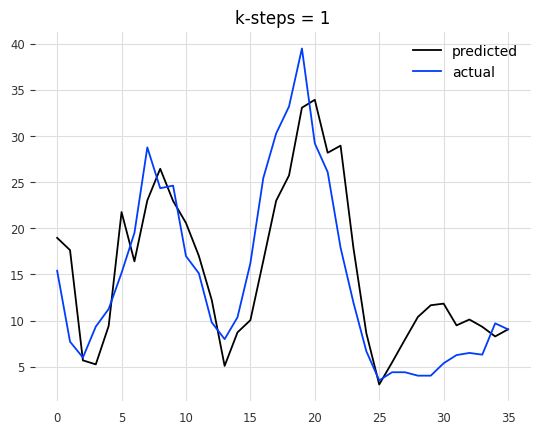

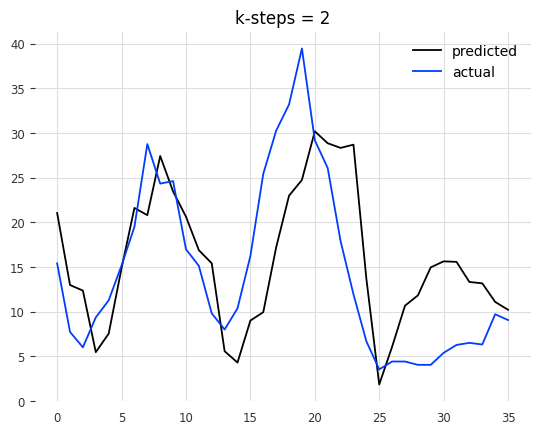

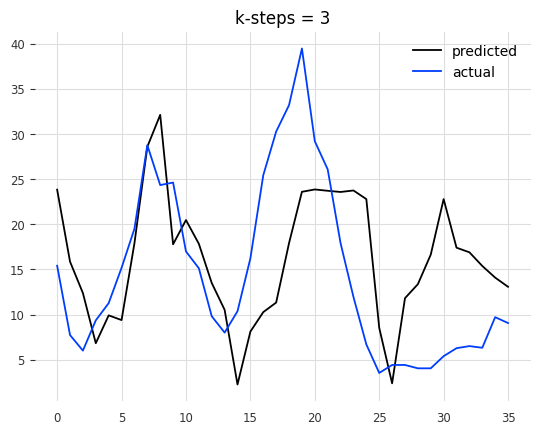

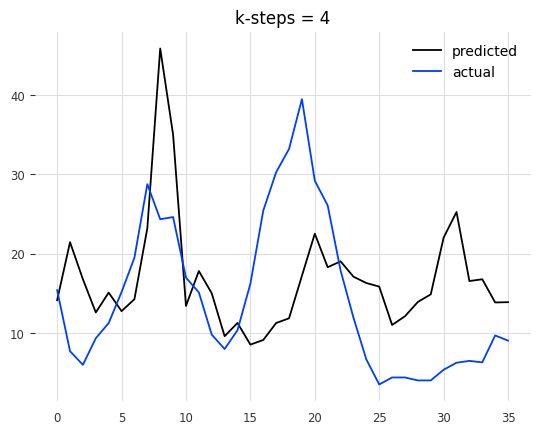

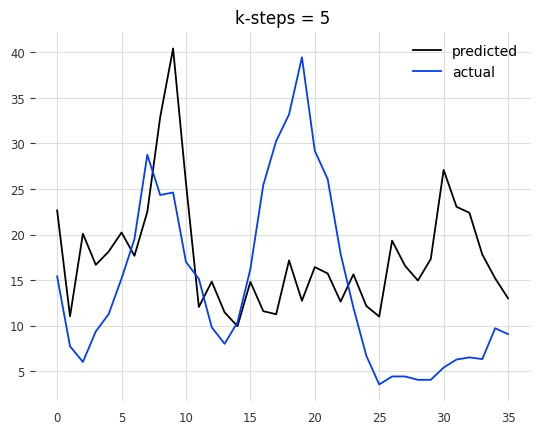

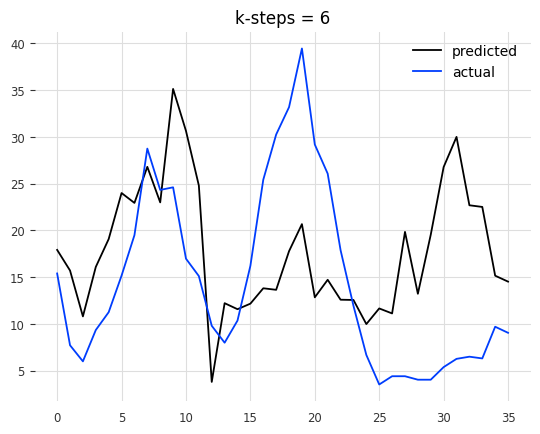

[I 2023-11-08 02:17:43,792] Trial 0 finished with value: 7.653770304564441 and parameters: {'Epochs': 310, 'Learning rate': 0.00019539587299202845, 'Num. filters': [100, 100, 100], 'Dropout rate': 0.3622613693599695}. Best is trial 0 with value: 7.653770304564441.
[I 2023-11-08 02:17:43,807] A new study created in memory with name: no-name-09e87f09-5e40-45a2-b0fc-420004d7040f


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
  Value:  7.653770304564441
🔥🔥🔥🔥🔥🔥🔥🔥BR Vũng Tàu
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Min_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 CNN
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN
🍭🍭🍭🍭🍭
Epoch:  0/110 - train_loss: 0.7585 - test_loss: 0.584736
Epoch: 27/110 - train_loss: 0.0722 - test_loss: 0.030024
Epoch: 54/110 - train_loss: 0.0643 - test_loss: 0.023127
Epoch: 81/110 - train_loss: 0.0579 - test_loss: 0.025821
Epoch: 108/110 - train_loss: 0.0473 - test_loss: 0.026366
Epoch: 109/110 - train_loss: 0.0599 - test_loss: 0.024753


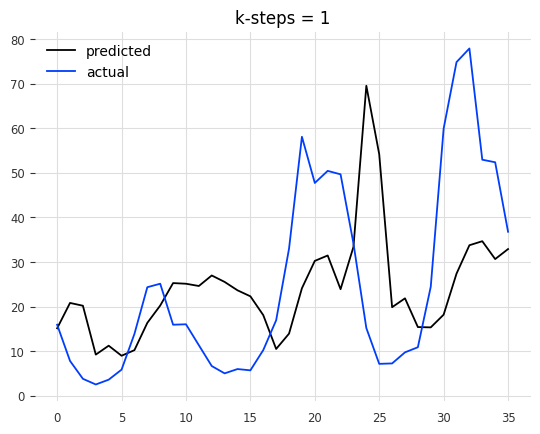

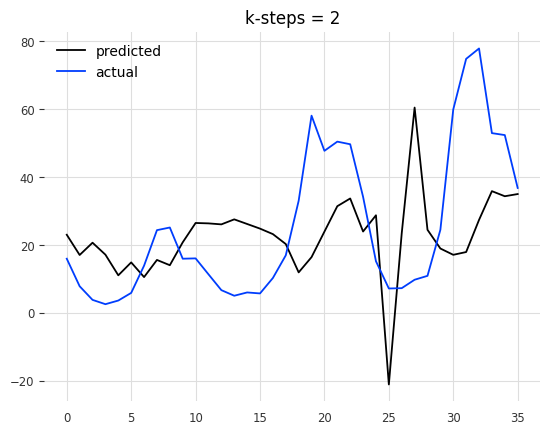

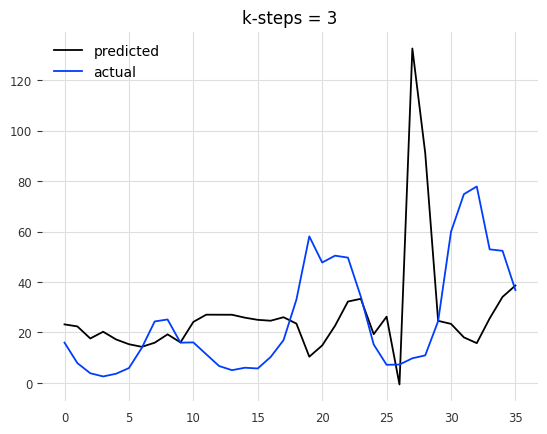

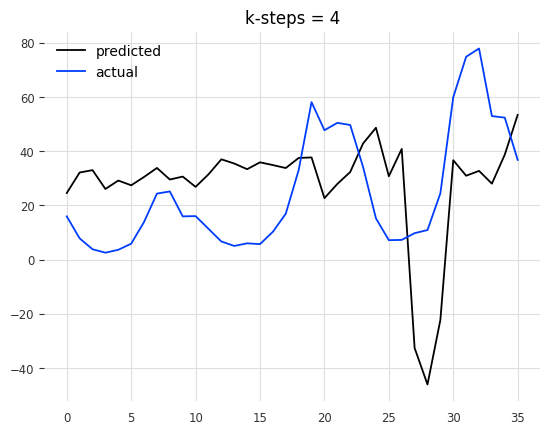

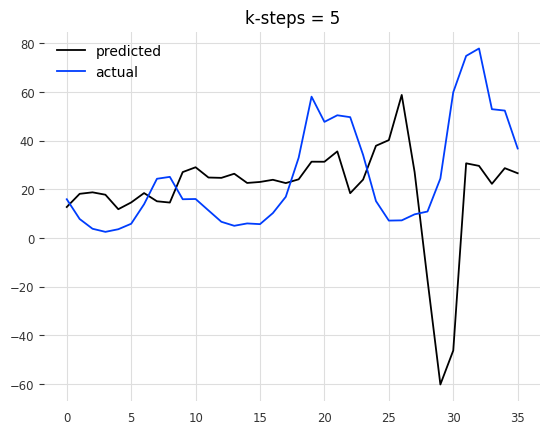

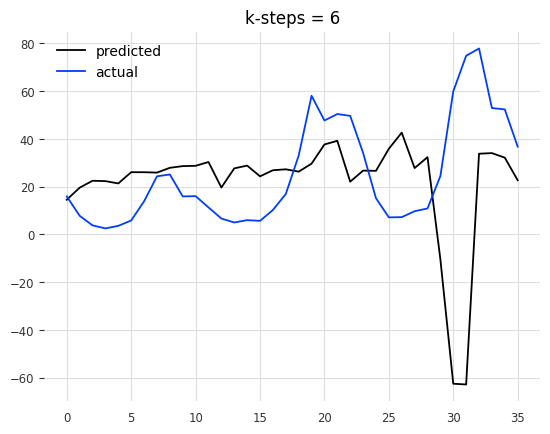

[I 2023-11-08 02:17:45,845] Trial 0 finished with value: 21.394408219433217 and parameters: {'Epochs': 110, 'Learning rate': 0.0041321169784815405, 'Num. filters': [64, 64, 64], 'Dropout rate': 0.5346739480648494}. Best is trial 0 with value: 21.394408219433217.
[I 2023-11-08 02:17:45,854] A new study created in memory with name: no-name-6f8ad61c-c953-4928-a9d0-0297f5b218f8


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
  Value:  21.394408219433217
🔥🔥🔥🔥🔥🔥🔥🔥Bình Phước
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 CNN
🌷🌷🌷🌷🌷🌷🌷🌷🌷
CNN
🍭🍭🍭🍭🍭
Epoch:  0/490 - train_loss: 0.8975 - test_loss: 0.838367
Epoch: 122/490 - train_loss: 0.3791 - test_loss: 0.371302
Epoch: 244/490 - train_loss: 0.1983 - test_loss: 0.212425
Epoch: 366/490 - train_loss: 0.1237 - test_loss: 0.158489
Epoch: 488/490 - train_loss: 0.0990 - test_loss: 0.150520
Epoch: 489/490 - train_loss: 0.1012 - test_loss: 0.149097


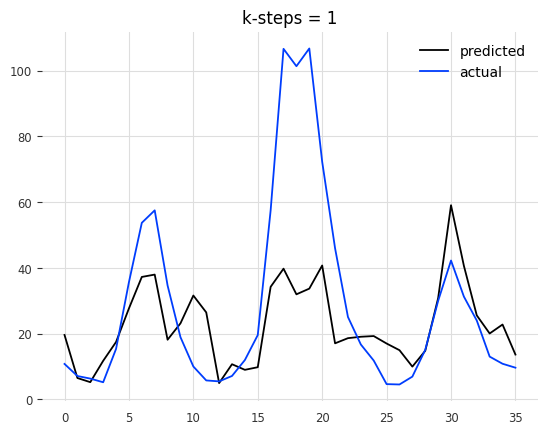

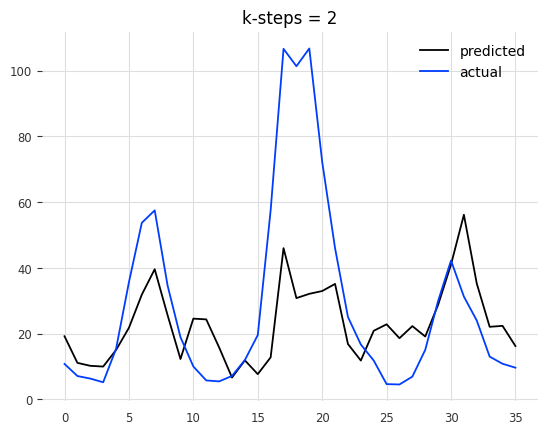

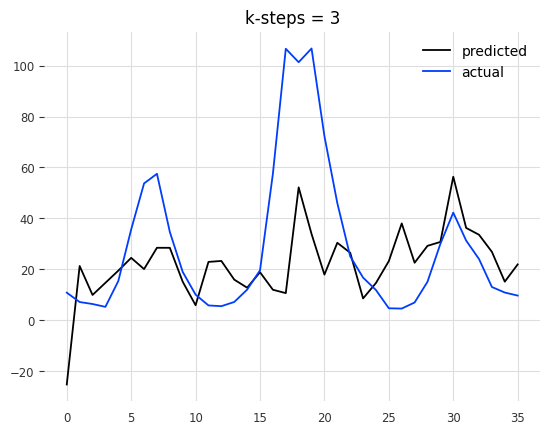

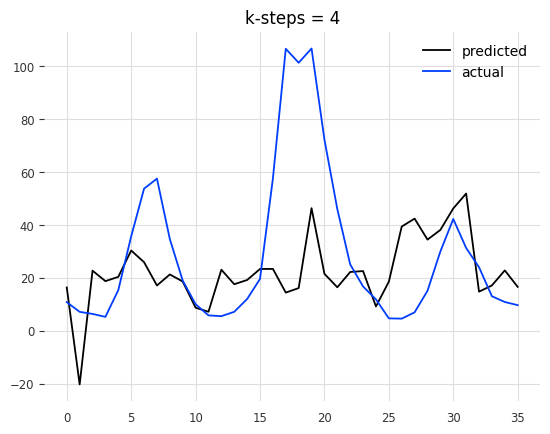

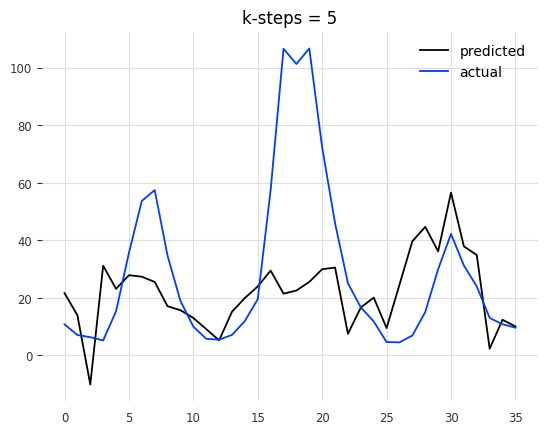

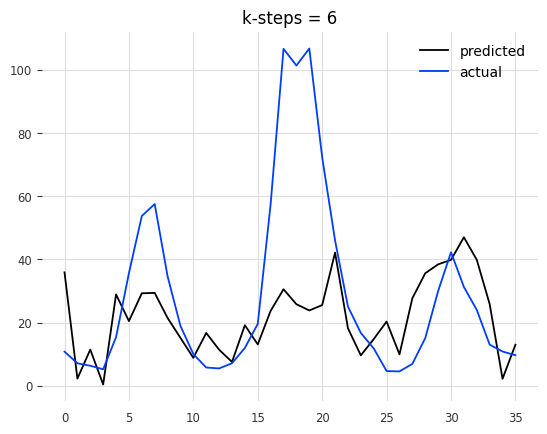

[I 2023-11-08 02:17:52,936] Trial 0 finished with value: 17.801559557478296 and parameters: {'Epochs': 490, 'Learning rate': 0.00013056175008422695, 'Num. filters': [128, 128, 128], 'Dropout rate': 0.2661132726944175}. Best is trial 0 with value: 17.801559557478296.
[I 2023-11-08 02:17:52,944] A new study created in memory with name: no-name-d2fb1c12-9aab-4ba3-935e-01d91ff916d4


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
  Value:  17.801559557478296
🔥🔥🔥🔥🔥🔥🔥🔥🔥LSTM
🔥🔥🔥🔥🔥🔥🔥🔥An Giang
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Daily_Rainfall', 'Average_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM
🍭🍭🍭🍭🍭
Epoch:  0/360 - train_loss: 0.8548 - test_loss: 0.630831
Epoch: 90/360 - train_loss: 0.4480 - test_loss: 0.216995
Epoch: 180/360 - train_loss: 0.4541 - test_loss: 0.202870
Epoch: 270/360 - train_loss: 0.4468 - test_loss: 0.214699
Epoch: 359/360 - train_loss: 0.4493 - test_loss: 0.206764


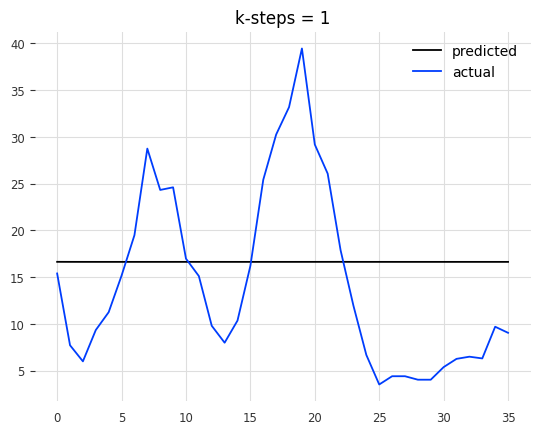

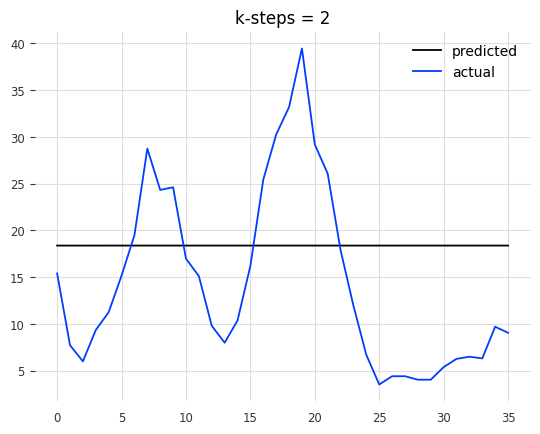

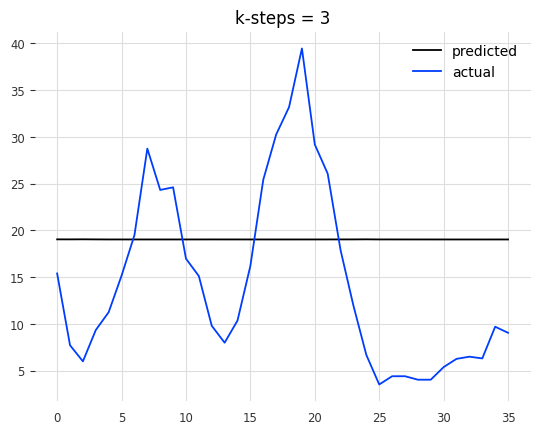

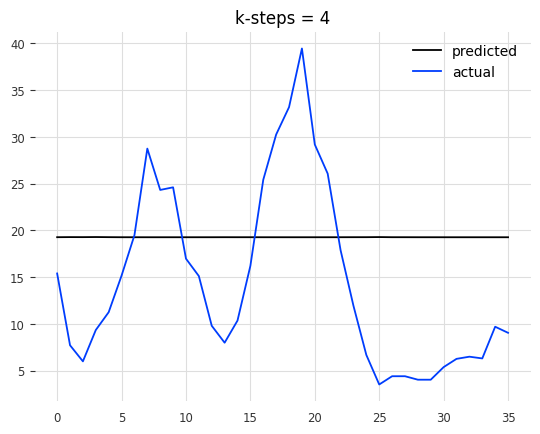

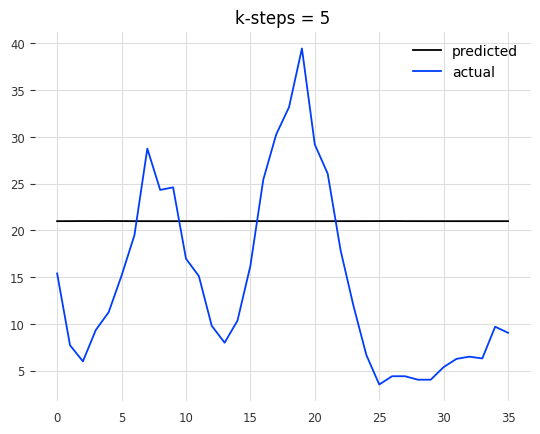

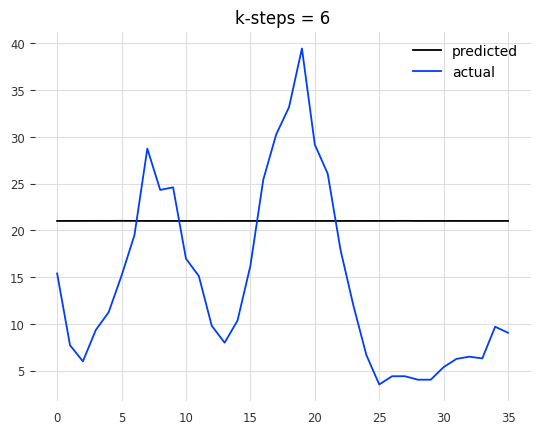

[I 2023-11-08 02:18:27,233] Trial 0 finished with value: 9.67888128079029 and parameters: {'Epochs': 360, 'Hidden size': 102, 'n layers': 8, 'Learning rate': 0.0037579166482686124}. Best is trial 0 with value: 9.67888128079029.
[I 2023-11-08 02:18:27,243] A new study created in memory with name: no-name-d7a72891-6deb-4e37-a487-ff6daef0291c


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
  Value:  9.67888128079029
🔥🔥🔥🔥🔥🔥🔥🔥BR Vũng Tàu
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Min_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM
🍭🍭🍭🍭🍭
Epoch:  0/320 - train_loss: 0.8509 - test_loss: 0.667451
Epoch: 80/320 - train_loss: 0.0812 - test_loss: 0.024848
Epoch: 160/320 - train_loss: 0.0805 - test_loss: 0.024658
Epoch: 240/320 - train_loss: 0.0702 - test_loss: 0.022141
Epoch: 319/320 - train_loss: 0.0584 - test_loss: 0.018155


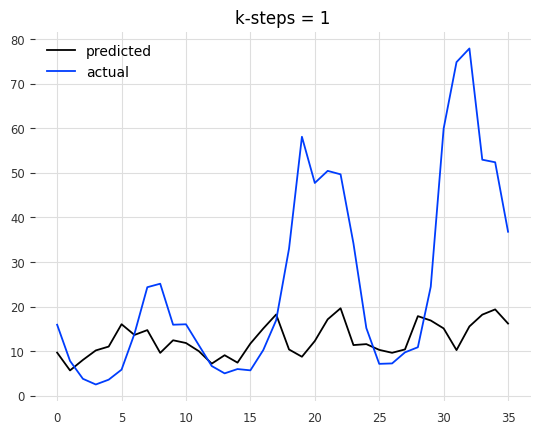

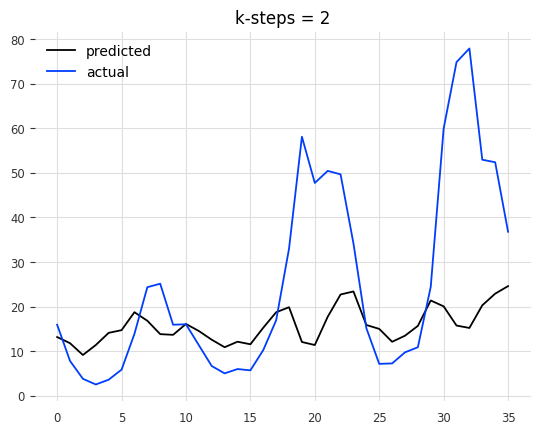

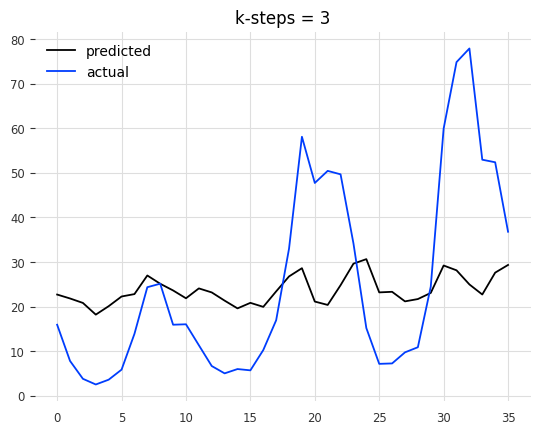

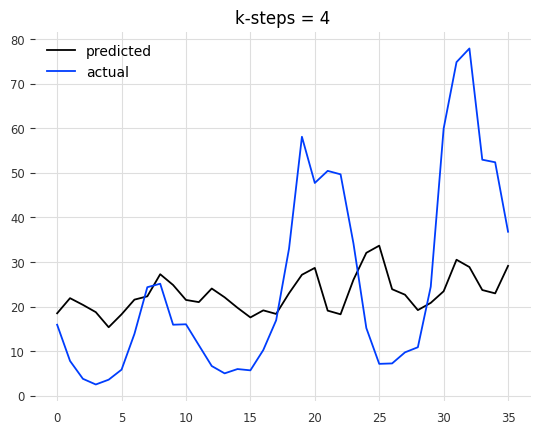

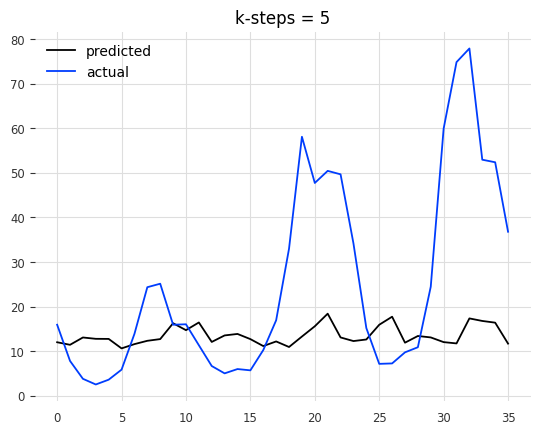

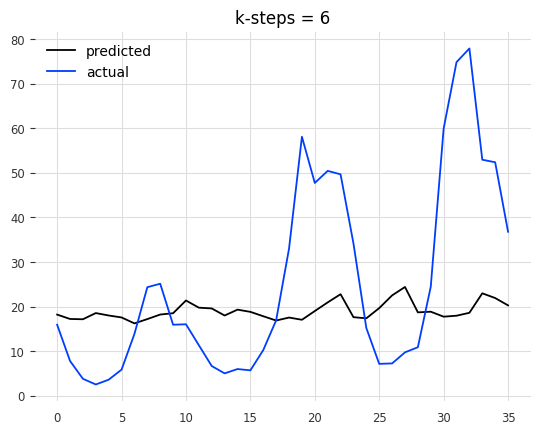

[I 2023-11-08 02:18:32,378] Trial 0 finished with value: 16.158311156363894 and parameters: {'Epochs': 320, 'Hidden size': 5, 'n layers': 4, 'Learning rate': 0.005239947185073777}. Best is trial 0 with value: 16.158311156363894.
[I 2023-11-08 02:18:32,386] A new study created in memory with name: no-name-f5aedc66-ab79-43a6-b4d5-781e4ea70758


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
  Value:  16.158311156363894
🔥🔥🔥🔥🔥🔥🔥🔥Bình Phước
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM
🍭🍭🍭🍭🍭
Epoch:  0/230 - train_loss: 0.6706 - test_loss: 0.535638
Epoch: 57/230 - train_loss: 0.1022 - test_loss: 0.155739
Epoch: 114/230 - train_loss: 0.1092 - test_loss: 0.179776
Epoch: 171/230 - train_loss: 0.1096 - test_loss: 0.153810
Epoch: 228/230 - train_loss: 0.0503 - test_loss: 0.167084
Epoch: 229/230 - train_loss: 0.0573 - test_loss: 0.172016


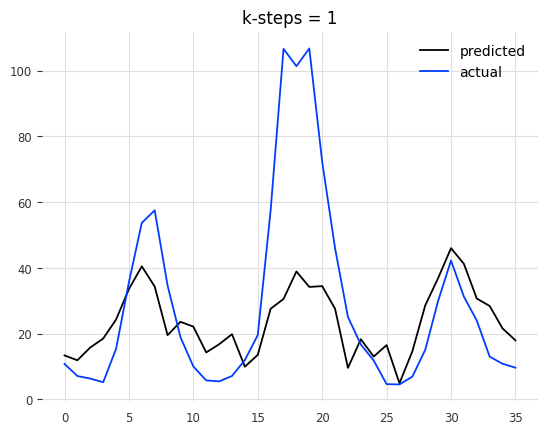

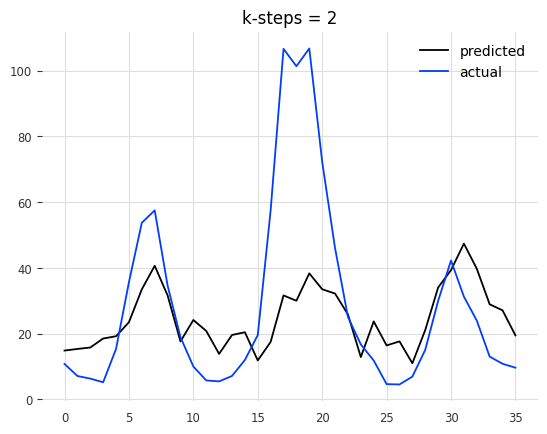

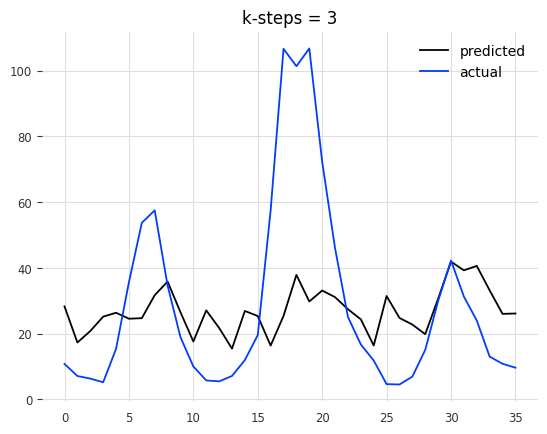

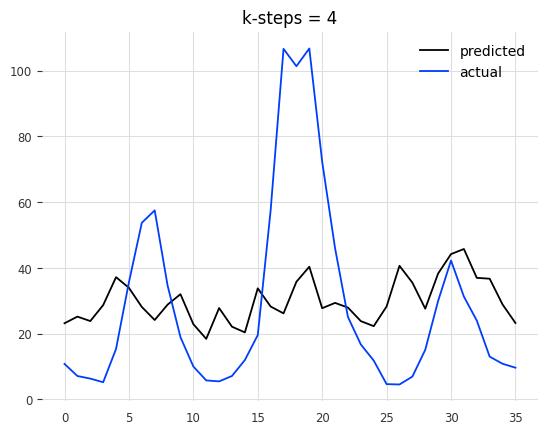

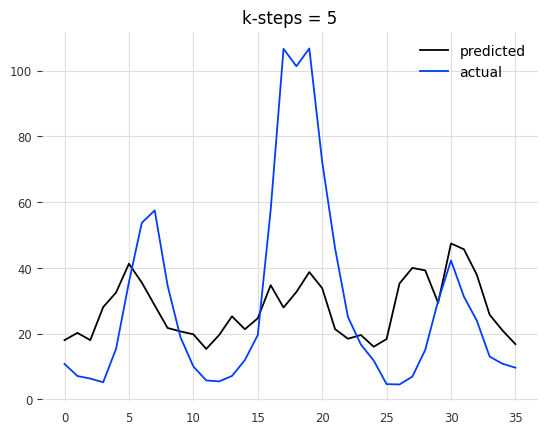

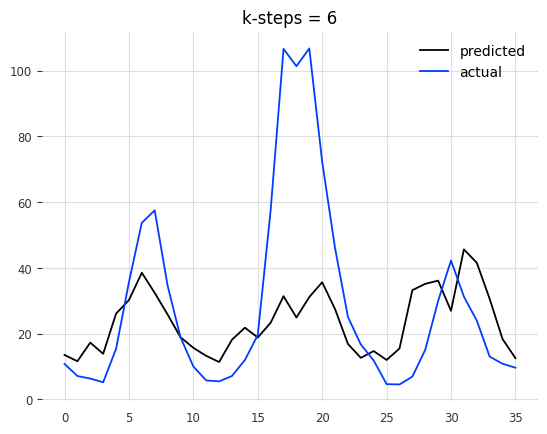

[I 2023-11-08 02:18:37,741] Trial 0 finished with value: 18.18684590489985 and parameters: {'Epochs': 230, 'Hidden size': 18, 'n layers': 5, 'Learning rate': 0.0074313011380649245}. Best is trial 0 with value: 18.18684590489985.
[I 2023-11-08 02:18:37,748] A new study created in memory with name: no-name-4f01553d-a99e-4ba8-aa4b-f89c293bc5d7


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
  Value:  18.18684590489985
🔥🔥🔥🔥🔥🔥🔥🔥🔥LSTM_ATT
🔥🔥🔥🔥🔥🔥🔥🔥An Giang
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Daily_Rainfall', 'Average_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM_ATT
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM_ATT
🍭🍭🍭🍭🍭
Epoch:  0/430 - train_loss: 1.7458 - test_loss: 1.471608
Epoch: 107/430 - train_loss: 0.4472 - test_loss: 0.211969
Epoch: 214/430 - train_loss: 0.4369 - test_loss: 0.210493
Epoch: 321/430 - train_loss: 0.4070 - test_loss: 0.204580
Epoch: 428/430 - train_loss: 0.3750 - test_loss: 0.204268
Epoch: 429/430 - train_loss: 0.3761 - test_loss: 0.201962


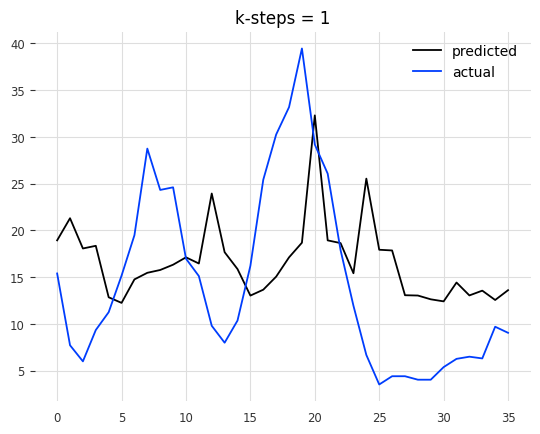

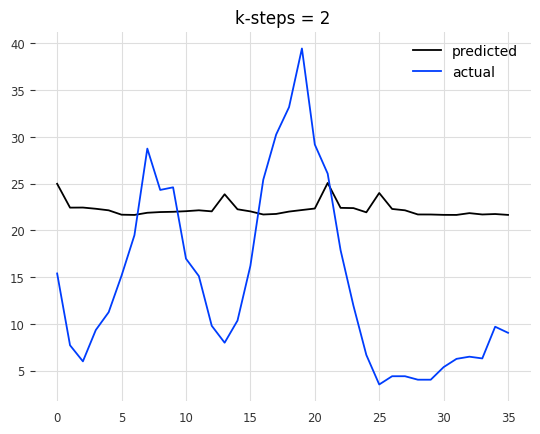

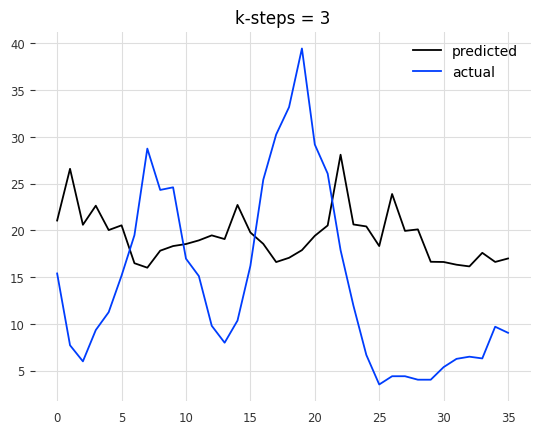

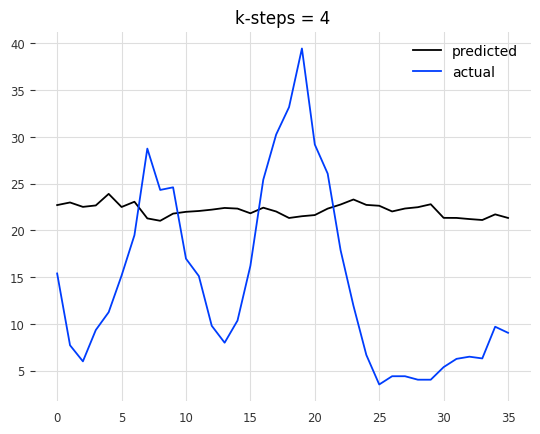

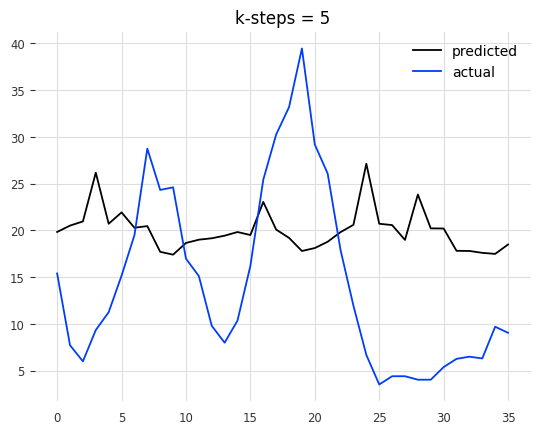

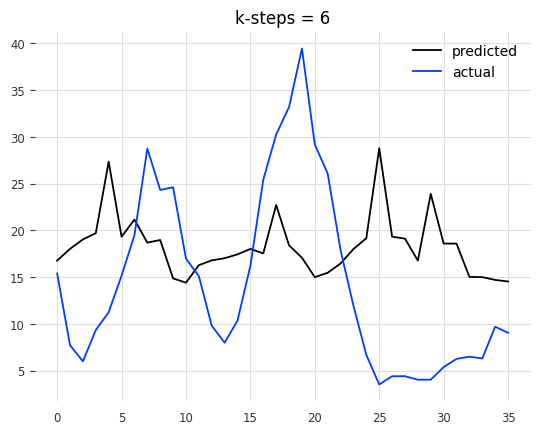

[I 2023-11-08 02:18:49,940] Trial 0 finished with value: 10.231083223931886 and parameters: {'Epochs': 430, 'Hidden size': 2, 'n layers': 7, 'Learning rate': 0.0009132701794202391}. Best is trial 0 with value: 10.231083223931886.
[I 2023-11-08 02:18:49,948] A new study created in memory with name: no-name-807a93f2-b598-49b7-8604-1d9cb3a4ab88


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
  Value:  10.231083223931886
🔥🔥🔥🔥🔥🔥🔥🔥BR Vũng Tàu
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Min_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM_ATT
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM_ATT
🍭🍭🍭🍭🍭
Epoch:  0/120 - train_loss: 1.0377 - test_loss: 0.849732
Epoch: 30/120 - train_loss: 0.0989 - test_loss: 0.028030
Epoch: 60/120 - train_loss: 0.0980 - test_loss: 0.028149
Epoch: 90/120 - train_loss: 0.0983 - test_loss: 0.029378
Epoch: 119/120 - train_loss: 0.0984 - test_loss: 0.029516


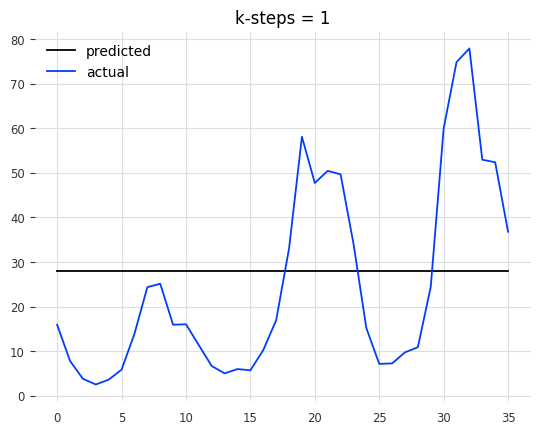

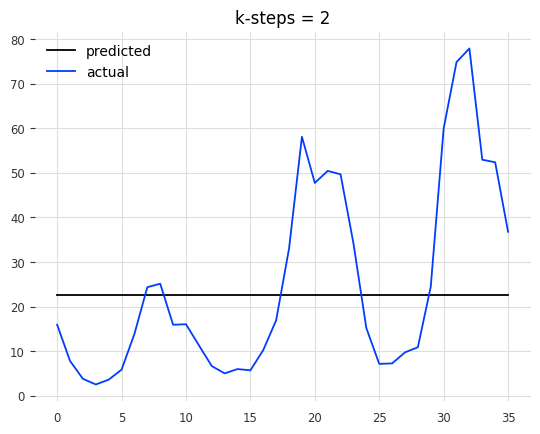

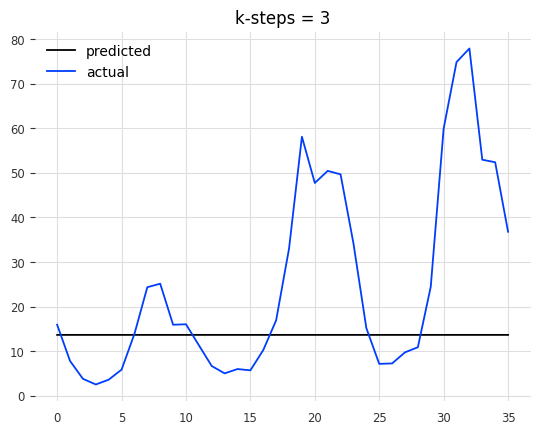

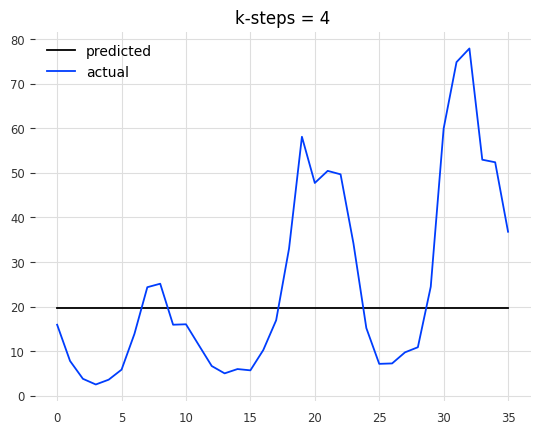

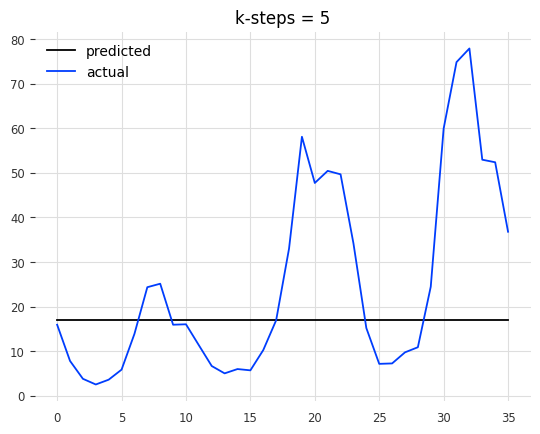

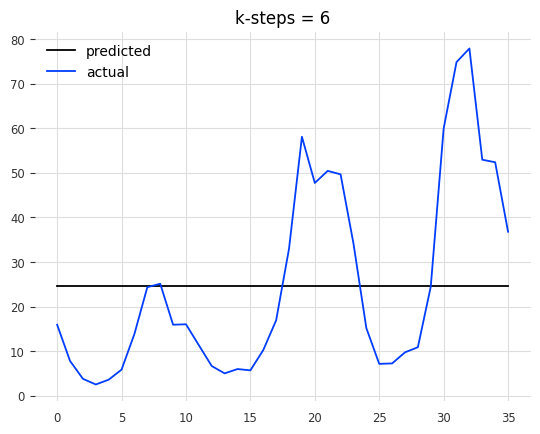

[I 2023-11-08 02:18:54,590] Trial 0 finished with value: 17.70333431893316 and parameters: {'Epochs': 120, 'Hidden size': 2, 'n layers': 9, 'Learning rate': 0.0063513674019712845}. Best is trial 0 with value: 17.70333431893316.
[I 2023-11-08 02:18:54,598] A new study created in memory with name: no-name-d7e48c8d-952c-4e5d-97be-b66afe2a3a2c


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
  Value:  17.70333431893316
🔥🔥🔥🔥🔥🔥🔥🔥Bình Phước
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 LSTM_ATT
🌷🌷🌷🌷🌷🌷🌷🌷🌷
LSTM_ATT
🍭🍭🍭🍭🍭
Epoch:  0/270 - train_loss: 0.8077 - test_loss: 0.793762
Epoch: 67/270 - train_loss: 0.1726 - test_loss: 0.167067
Epoch: 134/270 - train_loss: 0.1556 - test_loss: 0.146813
Epoch: 201/270 - train_loss: 0.1491 - test_loss: 0.136184
Epoch: 268/270 - train_loss: 0.1411 - test_loss: 0.131724
Epoch: 269/270 - train_loss: 0.1421 - test_loss: 0.132748


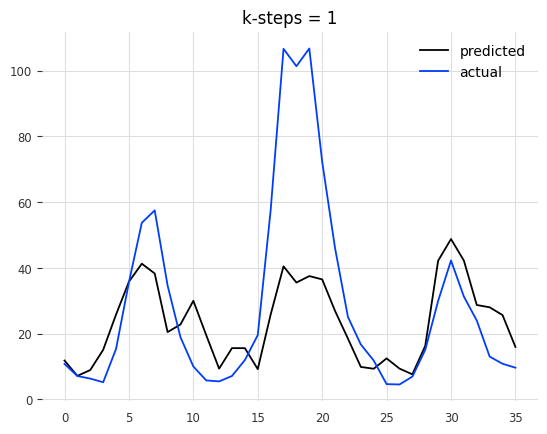

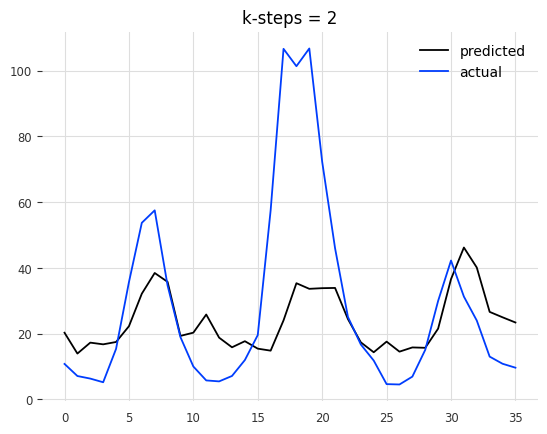

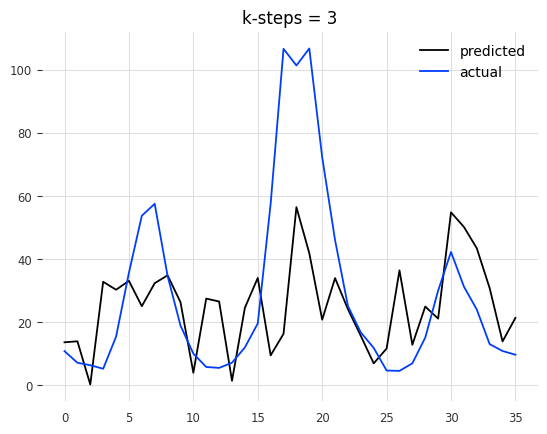

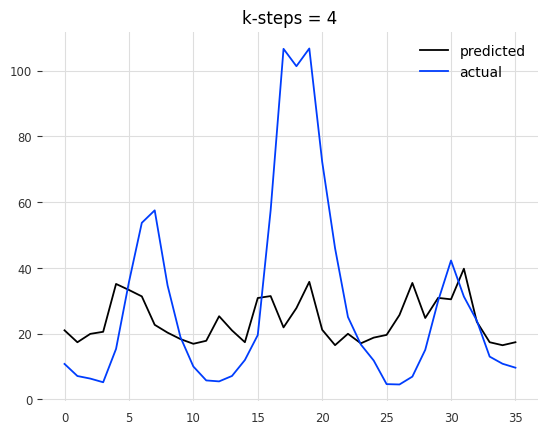

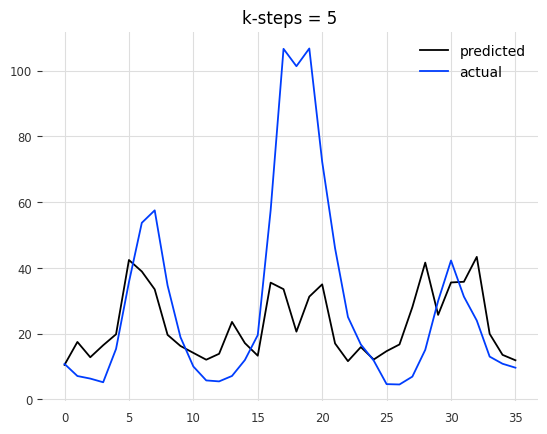

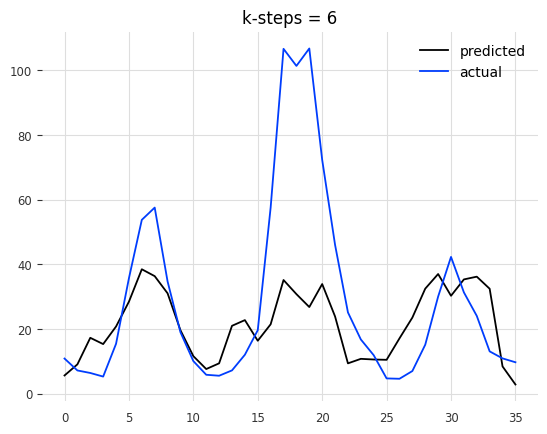

[I 2023-11-08 02:19:01,753] Trial 0 finished with value: 16.796218475445194 and parameters: {'Epochs': 270, 'Hidden size': 8, 'n layers': 5, 'Learning rate': 0.0008198202058330027}. Best is trial 0 with value: 16.796218475445194.
[I 2023-11-08 02:19:01,761] A new study created in memory with name: no-name-13666801-f9d5-436f-b5af-fa5a92c307ed


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
  Value:  16.796218475445194
🔥🔥🔥🔥🔥🔥🔥🔥🔥TRANSFORMERS
🔥🔥🔥🔥🔥🔥🔥🔥An Giang
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Daily_Rainfall', 'Average_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 TRANSFORMERS
🌷🌷🌷🌷🌷🌷🌷🌷🌷
TRANSFORMERS
🍭🍭🍭🍭🍭
Epoch:  0/140 - train_loss: 1.4541 - test_loss: 0.989380
Epoch: 35/140 - train_loss: 0.4595 - test_loss: 0.212510
Epoch: 70/140 - train_loss: 0.4549 - test_loss: 0.223638
Epoch: 105/140 - train_loss: 0.4460 - test_loss: 0.226149
Epoch: 139/140 - train_loss: 0.4619 - test_loss: 0.193679


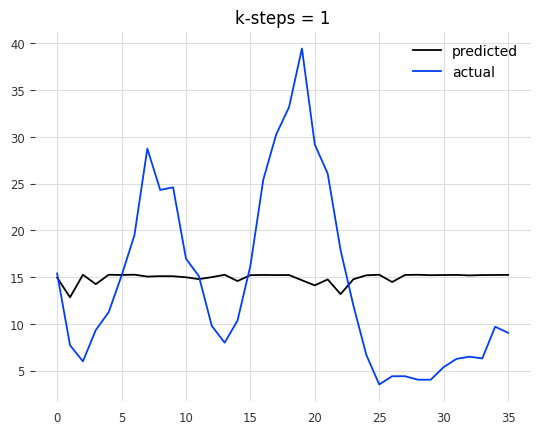

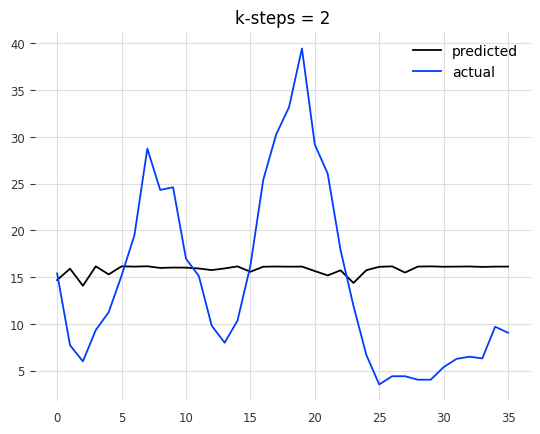

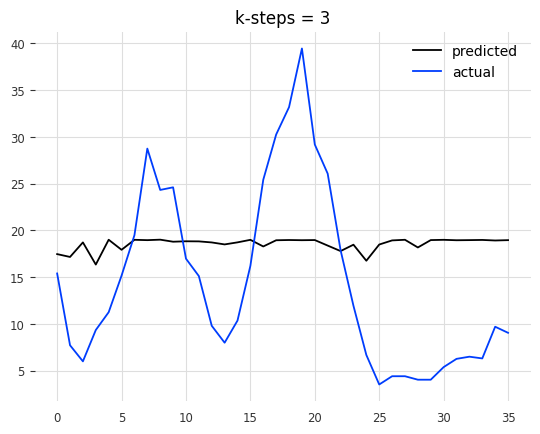

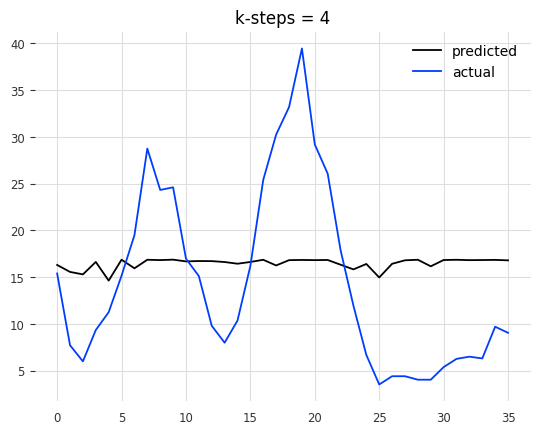

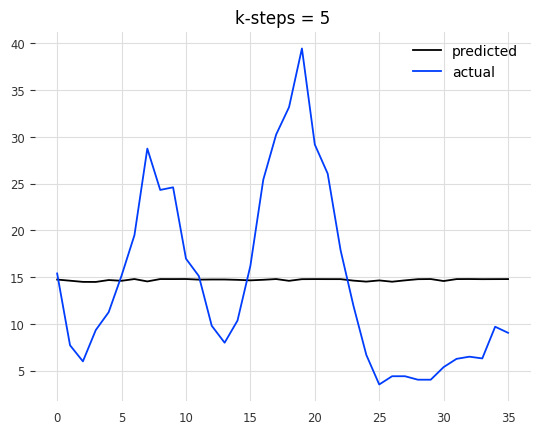

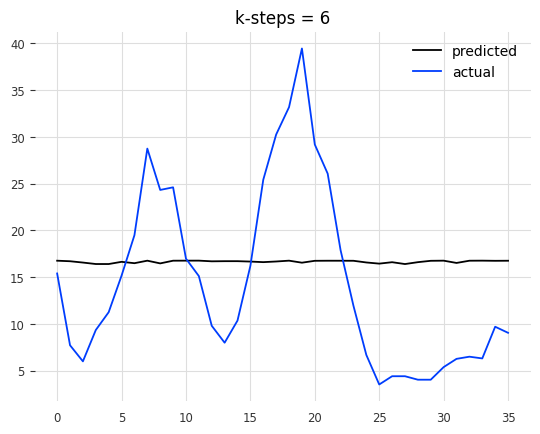

[I 2023-11-08 02:19:10,949] Trial 0 finished with value: 8.44849394287389 and parameters: {'n layers': 6, 'Hidden size': 6, 'Learning rate': 0.00470012549646984, 'Dropout rate': 0.7706198396614505, 'Epochs': 140}. Best is trial 0 with value: 8.44849394287389.
[I 2023-11-08 02:19:10,959] A new study created in memory with name: no-name-acf34f13-cc64-4c91-8d59-39d75fce1e08


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  An Giang
  Value:  8.44849394287389
🔥🔥🔥🔥🔥🔥🔥🔥BR Vũng Tàu
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Min_Humidity', 'Dengue_fever_rates']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 TRANSFORMERS
🌷🌷🌷🌷🌷🌷🌷🌷🌷
TRANSFORMERS
🍭🍭🍭🍭🍭
Epoch:  0/460 - train_loss: 1.8939 - test_loss: 1.211052
Epoch: 115/460 - train_loss: 0.1015 - test_loss: 0.038667
Epoch: 230/460 - train_loss: 0.0978 - test_loss: 0.028525
Epoch: 345/460 - train_loss: 0.0980 - test_loss: 0.028283
Epoch: 459/460 - train_loss: 0.0975 - test_loss: 0.028316


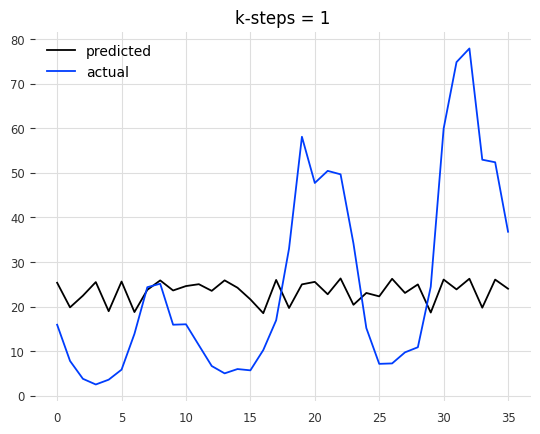

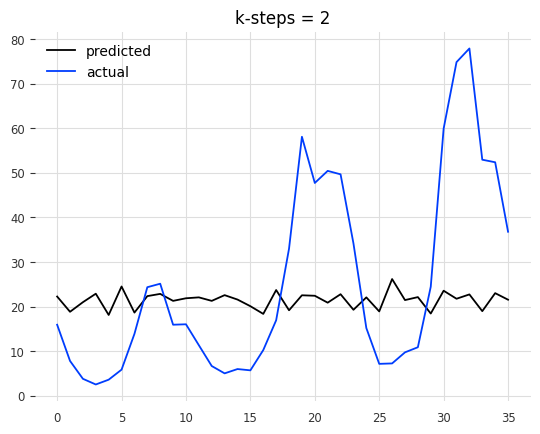

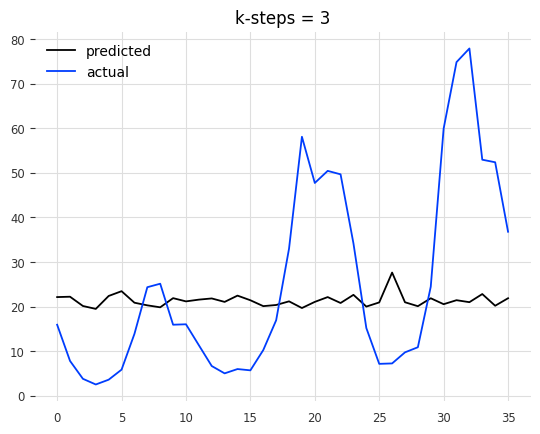

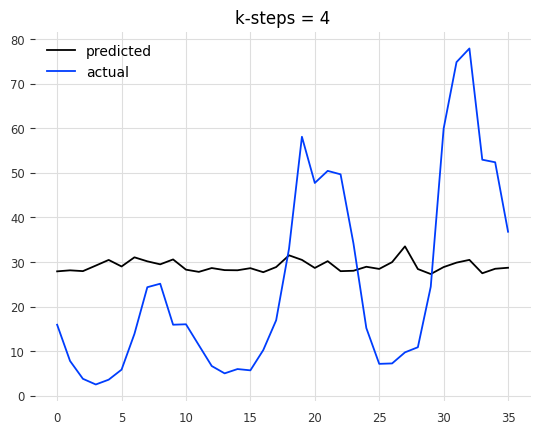

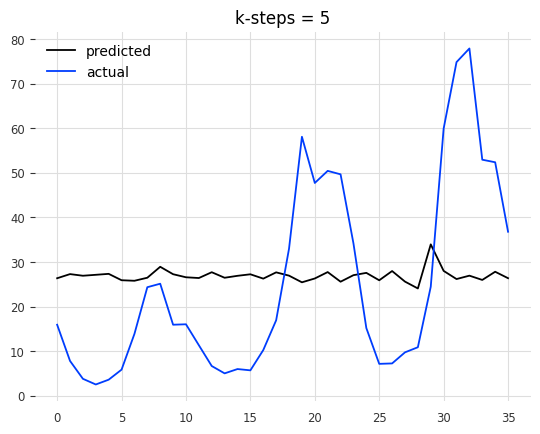

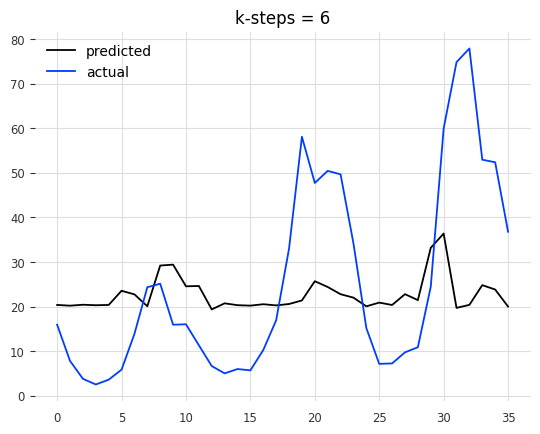

[I 2023-11-08 02:19:25,538] Trial 0 finished with value: 18.137393445782756 and parameters: {'n layers': 3, 'Hidden size': 10, 'Learning rate': 0.0006083271769285531, 'Dropout rate': 0.7158224779009916, 'Epochs': 460}. Best is trial 0 with value: 18.137393445782756.
[I 2023-11-08 02:19:25,551] A new study created in memory with name: no-name-35c8784c-07be-4c6d-8c07-107ce5464ce6


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  BR Vũng Tàu
  Value:  18.137393445782756
🔥🔥🔥🔥🔥🔥🔥🔥Bình Phước
🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤🍤
Selected_features  ['Max_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity']
🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉🍉 TRANSFORMERS
🌷🌷🌷🌷🌷🌷🌷🌷🌷
TRANSFORMERS
🍭🍭🍭🍭🍭
Epoch:  0/390 - train_loss: 1.4918 - test_loss: 1.026795
Epoch: 97/390 - train_loss: 0.1625 - test_loss: 0.159333
Epoch: 194/390 - train_loss: 0.1656 - test_loss: 0.159130
Epoch: 291/390 - train_loss: 0.1635 - test_loss: 0.155492
Epoch: 388/390 - train_loss: 0.1623 - test_loss: 0.154144
Epoch: 389/390 - train_loss: 0.1628 - test_loss: 0.155418


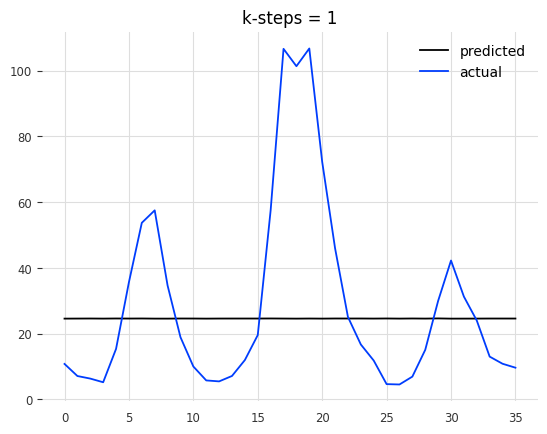

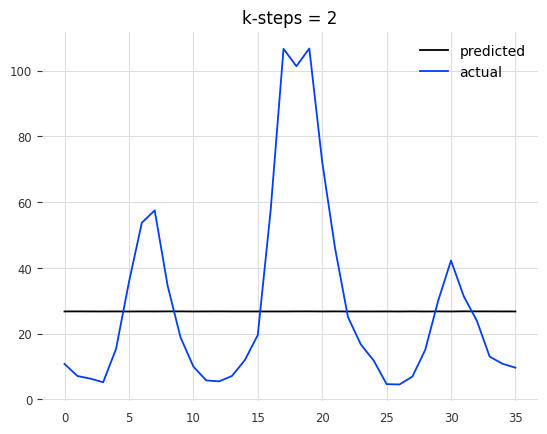

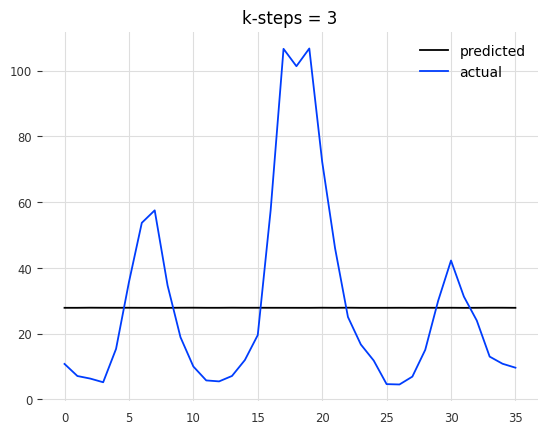

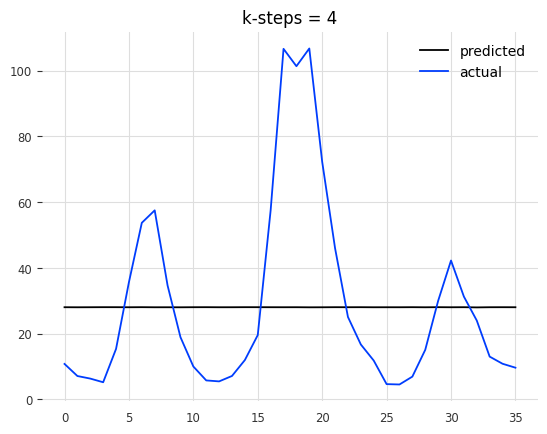

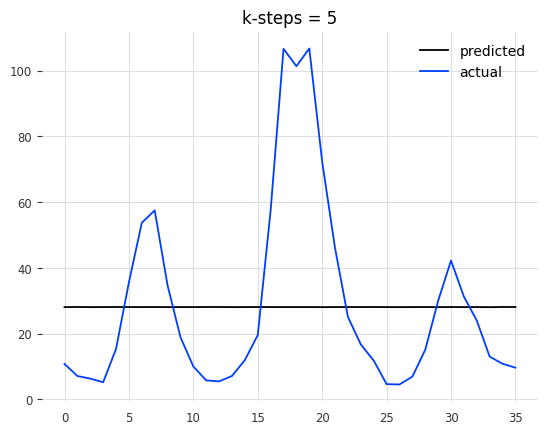

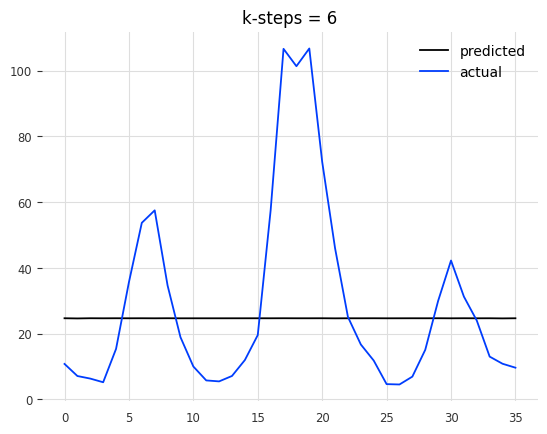

[I 2023-11-08 02:19:46,572] Trial 0 finished with value: 21.562938104610478 and parameters: {'n layers': 5, 'Hidden size': 52, 'Learning rate': 0.006158242849752272, 'Dropout rate': 0.6765840656597171, 'Epochs': 390}. Best is trial 0 with value: 21.562938104610478.


Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
  Value:  21.562938104610478
kết thúc study trong: 2


In [78]:
#########################
# Main Cell for optimize
#########################
model_name_list = [
     "CNN",
     "LSTM",
     "LSTM_ATT",
     "TRANSFORMERS",    
]

dt_started = datetime.now()

# Input param for Optimize Run
ntry = args.ntry
njob = args.njob


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]
 

if __name__ == '__main__':  
  for model_name in model_name_list: 
    print(f"🔥🔥🔥🔥🔥🔥🔥🔥🔥{model_name}")
    for city_index in range(len(cities)):
      print(f"🔥🔥🔥🔥🔥🔥🔥🔥{cities[city_index]}")
      # Use Tree-structured Parzen Estimator sampler to minimise RMSE
      sampler = optuna.samplers.TPESampler()
      study = optuna.create_study(sampler=sampler, direction='minimize')

      # truyền multiple param vào trong biến trial
      obj_func = lambda trial: objective(model_name,trial, cities[city_index])

      try:
        # Optimise over 100 trials
        study.optimize(obj_func, n_trials=ntry, n_jobs=njob)

        # Print results
        print("Study statistics for : ")
        print("  Number of finished trials: ", len(study.trials))
    
        
        print("Best trial of city: ",cities[city_index])
        best_trial = study.best_trial
        print("  Value: ", best_trial.value)   
        if model_name == "CNN":
          # lưu best param vào trong biến toàn cục
          one_city_param = pd.DataFrame({                     
                                  'City': [cities[city_index]],
                                  'Alg_name': 'CNN',
                                  'Best_value': best_trial.value,
                                  'n_try_opt': ntry,
                                  'n Feature': args.n_features, # dùng chung cho tất cả các model và algorithm
                                  'Batch Size': args.batch_size, # dùng chung cho tất cả các model và algorithm
                                  'Lookback Window': args.look_back, # dùng chung cho tất cả các tỉnh của CNN
                                  'Epochs': best_trial.params['Epochs'],
                                  'Hiden Size': '', # CNN không quan tâm
                                  'n Layers': '', # CNN không quan tâm
                                  'Learning rate': best_trial.params['Learning rate'], 
                                  'Num. filters': concate_2_filter_str(best_trial.params['Num. filters']), # đoạn này ép kiểu không sẽ thành x 3 do cấu trúc [] 
                                  'Dropout rate': best_trial.params['Dropout rate']}, index=[0])
        elif model_name == "LSTM":
          # lưu best param vào trong biến toàn cục
          one_city_param = pd.DataFrame({                     
                              'City': [cities[city_index]],
                              'Alg_name': 'LSTM',
                              'Best_value': best_trial.value,
                              'n_try_opt': ntry,
                              'n Feature': args.n_features, # dùng chung cho tất cả các model và algorithm
                              'Batch Size': args.batch_size, # dùng chung cho tất cả các model và algorithm
                              'Lookback Window': args.look_back, 
                              'Epochs': best_trial.params['Epochs'],
                              'Hiden Size': best_trial.params['Hidden size'], 
                              'n Layers': best_trial.params['n layers'],
                              'Learning rate': best_trial.params['Learning rate'], 
                              'Num. filters': '', # đoạn này ép kiểu không sẽ thành x 3 do cấu trúc [] 
                              'Dropout rate': ''}, index=[0])
        elif model_name == "LSTM_ATT":
           one_city_param = pd.DataFrame({                     
                              'City': [cities[city_index]],
                              'Alg_name': 'LSTM_ATT',
                              'Best_value': best_trial.value,
                              'n_try_opt': ntry,
                              'n Feature': args.n_features, # dùng chung cho tất cả các model và algorithm
                              'Batch Size': args.batch_size, # dùng chung cho tất cả các model và algorithm
                              'Lookback Window': args.look_back, 
                              'Epochs': best_trial.params['Epochs'],
                              'Hiden Size': best_trial.params['Hidden size'], 
                              'n Layers': best_trial.params['n layers'],
                              'Learning rate': best_trial.params['Learning rate'], 
                              'Num. filters': '',  
                              'Dropout rate': ''}, index=[0])
        elif model_name == "TRANSFORMERS":
           one_city_param = pd.DataFrame({
                              'City': [cities[city_index]],
                              'Alg_name': 'transformer',
                              'Best_value': best_trial.value,
                              'n_try_opt': ntry,
                              'n Feature': args.n_features, # dùng chung cho tất cả các model và algorithm
                              'Batch Size': args.batch_size, # dùng chung cho tất cả các model và algorithm
                              'Lookback Window': args.look_back, 
                              'Epochs': best_trial.params['Epochs'],
                              'Hidden Size': best_trial.params['Hidden size'],
                              'n Layers': best_trial.params['n layers'],
                              'Learning rate': best_trial.params['Learning rate'], 
                              'Num. filters': '', # Transformer không dùng
                              'Dropout rate': best_trial.params['Dropout rate']}, index=[0])
        folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
        file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
        if(os.path.isfile(file_path)):
            with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
        else:
            if(not (os.path.isdir(folder_path))):
              os.mkdir(folder_path)
            with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                one_city_param.to_excel(writer, startrow=city_index,index=False)
      except:# có error thì lưu vào l_errCity để check lại sau 
        l_errCity.append(cities[city_index])
  # lưu kết quả vào file CNN
#   best_param.to_excel(prj_path_opt+'cnn/diarrhoea_opt_hyperparam_cnn.xlsx')

dt_ended = datetime.now()
print('kết thúc study trong:', round((dt_ended - dt_started).total_seconds()/60))

In [79]:
# send_to_telegram("Chạy xong optimize rùiii!!Vô check thuiii!!!" )